In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import qiskit
from qiskit import Aer

## Defining the circuit

In [2]:
n_qubits = 12
depth = 200
gates = [('RZZ', 2), ('RZ', 1), ('P', 1)]

In [3]:
qubits = qiskit.QuantumRegister(size=n_qubits, name='q')

In [4]:
circ = qiskit.QuantumCircuit(qubits)

The initial Hadamard transform:

In [5]:
circ.h(qubits)

We are randomly choosing between the following gates:
    
$$ RZ (\phi) = 
\begin{bmatrix}
1 & 0\\
0 & e^{i \phi}
\end{bmatrix}
\; ; \qquad
P (\phi) = RZ(\phi) X = 
\begin{bmatrix}
0 & 1\\
e^{i \phi} & 0
\end{bmatrix} $$

and a 2-qubit gate:

$$
RZZ (\phi) = 
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & e^{i \phi} & 0 & 0 \\
0 & 0 & e^{i \phi} & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

where $\phi$ is independently chosen as $\phi \sim \text{Uniform} (0, 2\pi )$ each time.

In [6]:
for k in range(depth):
    
    i = np.random.randint(low=0, high=len(gates))
    gate, nqs = gates[i]
    
    qs = np.random.choice(np.arange(n_qubits), size=nqs, replace=False)
    phi = np.random.uniform(low=0.0, high=2*np.pi)
    
    if gate=='RZ':
        circ.rz(phi, *qs)  
    elif gate=='RZZ':
        circ.rzz(phi, *qs)  
    elif gate=='P':
        circ.x(*qs)
        circ.rz(phi, *qs)

The final circuit diagram can be drawn with:

In [7]:
# circ.draw()

(up to the final hadamard transform)

## Simulating the circuit

In [8]:
backend = Aer.get_backend('statevector_simulator')

Simulate first without the final Hadamard transform:

In [9]:
%%time
job = qiskit.execute(circ, backend)

CPU times: user 241 ms, sys: 3.88 ms, total: 245 ms
Wall time: 244 ms


In [10]:
result = job.result()
psi = result.get_statevector(circ, decimals=30) # This "decimals" argument was set to 10 which was too low!
p = np.abs(psi)**2

Do a final Hadamard transform for comparison:

In [11]:
circ.h(qubits)

In [12]:
%%time
jobh = qiskit.execute(circ, backend)

CPU times: user 181 ms, sys: 3.07 ms, total: 184 ms
Wall time: 184 ms


In [13]:
resulth = jobh.result()
psih = resulth.get_statevector(circ, decimals=30) # This "decimals" argument was set to 10 which was too low!
ph = np.abs(psih)**2

Plot the result:

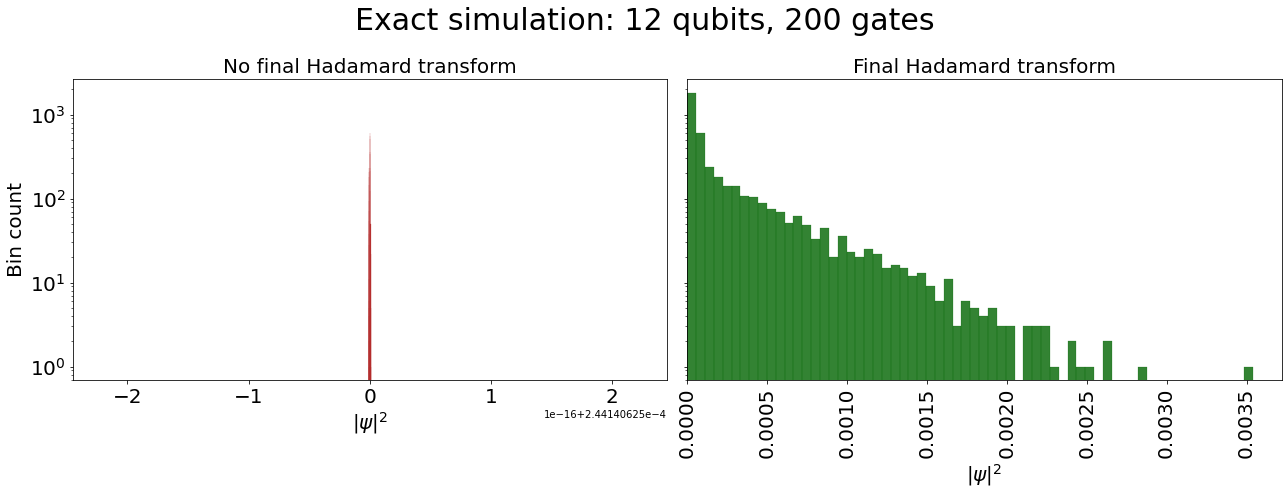

In [14]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=[18,7])

titles = ['No final Hadamard transform', 'Final Hadamard transform']
colors = ['firebrick', 'darkgreen']

for i, (ax, probs, title, color) in enumerate(zip(axes, [p, ph], titles, colors)):
    ax.set_yscale('log')
    ax.hist(probs, bins='sqrt', lw=0.25, color=color, edgecolor=color, alpha=0.8)

    ax.set_xlabel(r'$\vert \psi \vert ^2 $', fontsize=20)
    ax.set_title(title, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    if i==0:
        ax.set_ylabel(r'Bin count', fontsize=20)
    if i==1:
        ax.set_xlim(0)
        ax.tick_params(axis='x', rotation=90)
    
#     minp, maxp = np.min(p), np.max(p)
#     ax.axvline(x=minp, c='k', ls='--')
#     ax.axvline(x=maxp, c='k', ls='--')

fig.suptitle(r'Exact simulation: {} qubits, {} gates'.format(n_qubits, depth), fontsize=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

# plt.savefig('porter_thomas.pdf')